## import

In [29]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers

from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.r_aspp import MobileNetV2Seg

from tqdm import tqdm

# setting

In [30]:
artifacts_path = Path("../../artifacts/mobilenetv2-raspp")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [31]:
DEVICE = torch.device("cuda:0")

# data

In [32]:
BATCH_SIZE = 32
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [33]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [34]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [35]:
NUM_WORKERS = get_num_workers()

In [36]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

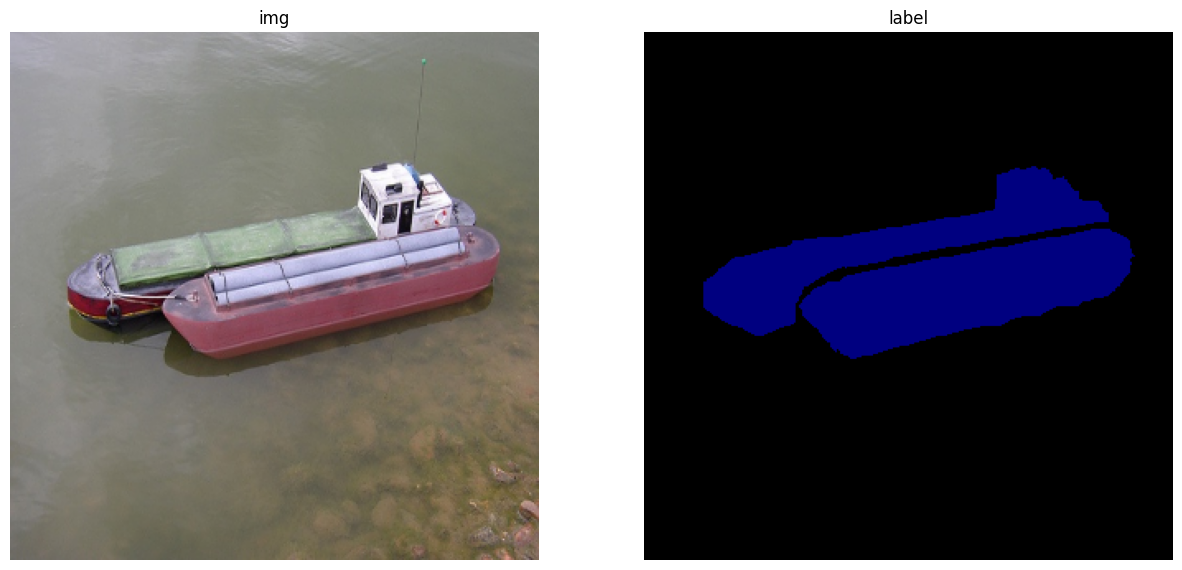

In [37]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [38]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([32, 3, 321, 321])
torch.Size([32, 321, 321])


# train

In [39]:
model = MobileNetV2Seg(
    output_size=NUM_CLASS + 1,
    reduction_ratio=4,
    frozen_backbone=True,
).to(DEVICE)

In [40]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
MobileNetV2Seg                                          --
├─MobileNetFeatureExtractor: 1-1                        --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2dNormActivation: 3-1                   (928)
│    │    └─InvertedResidual: 3-2                       (896)
│    │    └─InvertedResidual: 3-3                       (5,136)
│    │    └─InvertedResidual: 3-4                       (8,832)
│    │    └─InvertedResidual: 3-5                       (10,000)
│    │    └─InvertedResidual: 3-6                       (14,848)
│    │    └─InvertedResidual: 3-7                       (14,848)
│    │    └─InvertedResidual: 3-8                       (21,056)
│    │    └─InvertedResidual: 3-9                       (54,272)
│    │    └─InvertedResidual: 3-10                      (54,272)
│    │    └─InvertedResidual: 3-11                      (54,272)
│    │    └─InvertedResidual: 3-12                  

In [41]:
EPOCHS = 30

In [42]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)

In [43]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [45]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 91/91 [00:33<00:00,  2.71it/s]


epoch 1 : 0.04587398594306721


100%|██████████| 91/91 [00:34<00:00,  2.68it/s]


epoch 2 : 0.01927366010476272


100%|██████████| 91/91 [00:32<00:00,  2.80it/s]


epoch 3 : 0.015971578831610444


100%|██████████| 91/91 [00:33<00:00,  2.71it/s]


epoch 4 : 0.014107296192138404


100%|██████████| 91/91 [00:34<00:00,  2.64it/s]


epoch 5 : 0.013028394563921861


100%|██████████| 91/91 [00:33<00:00,  2.70it/s]


epoch 6 : 0.012462415435648227


100%|██████████| 91/91 [00:33<00:00,  2.74it/s]


epoch 7 : 0.011795944769631375


100%|██████████| 91/91 [00:32<00:00,  2.82it/s]


epoch 8 : 0.011412147186942154


100%|██████████| 91/91 [00:33<00:00,  2.72it/s]


epoch 9 : 0.011046876752196432


100%|██████████| 91/91 [00:31<00:00,  2.88it/s]


epoch 10 : 0.010708281524725013


100%|██████████| 91/91 [00:31<00:00,  2.85it/s]


epoch 11 : 0.010562091687141539


100%|██████████| 91/91 [00:32<00:00,  2.84it/s]


epoch 12 : 0.010456088705213515


100%|██████████| 91/91 [00:32<00:00,  2.81it/s]


epoch 13 : 0.010344946235008947


100%|██████████| 91/91 [00:31<00:00,  2.86it/s]


epoch 14 : 0.009974886975404653


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 15 : 0.009837275534704492


100%|██████████| 91/91 [00:31<00:00,  2.86it/s]


epoch 16 : 0.00959730948638785


100%|██████████| 91/91 [00:31<00:00,  2.86it/s]


epoch 17 : 0.009499411093541882


100%|██████████| 91/91 [00:33<00:00,  2.73it/s]


epoch 18 : 0.009425162163737056


100%|██████████| 91/91 [00:33<00:00,  2.75it/s]


epoch 19 : 0.009028939832165673


100%|██████████| 91/91 [00:32<00:00,  2.77it/s]


epoch 20 : 0.008978511324500317


100%|██████████| 91/91 [00:32<00:00,  2.80it/s]


epoch 21 : 0.00890386542100664


100%|██████████| 91/91 [00:32<00:00,  2.80it/s]


epoch 22 : 0.008862040220544888


100%|██████████| 91/91 [00:32<00:00,  2.80it/s]


epoch 23 : 0.008889801759313752


100%|██████████| 91/91 [00:33<00:00,  2.75it/s]


epoch 24 : 0.00877260024771913


100%|██████████| 91/91 [00:32<00:00,  2.77it/s]


epoch 25 : 0.008793535069204293


100%|██████████| 91/91 [00:31<00:00,  2.85it/s]


epoch 26 : 0.008722290688368318


100%|██████████| 91/91 [00:32<00:00,  2.78it/s]


epoch 27 : 0.008715830349291746


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 28 : 0.008880147787199899


100%|██████████| 91/91 [00:31<00:00,  2.87it/s]


epoch 29 : 0.008752979297231843


100%|██████████| 91/91 [00:31<00:00,  2.85it/s]

epoch 30 : 0.008750903583899305


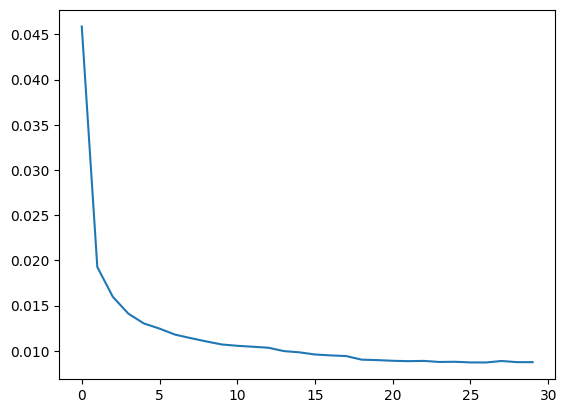

In [46]:
plt.plot(training_loss)

In [47]:
model_path = artifacts_path.joinpath('raspp.mobilenetv2.pth')

In [48]:
torch.save(model.state_dict(), model_path)

In [49]:
get_file_size(model_path)

'8.99MiB'

In [50]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [51]:
from torchmetrics.classification import jaccard

In [52]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


In [53]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.52 
bicycle        : 0.07 
bird           : 0.67 
boat           : 0.51 
bottle         : 0.39 
bus            : 0.65 
car            : 0.56 
cat            : 0.73 
chair          : 0.24 
cow            : 0.52 
diningtable    : 0.32 
dog            : 0.52 
horse          : 0.51 
motorbike      : 0.46 
person         : 0.59 
pottedplant    : 0.19 
sheep          : 0.56 
sofa           : 0.35 
train          : 0.7  
tvmonitor      : 0.5  
----------------------
total          : 0.48 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

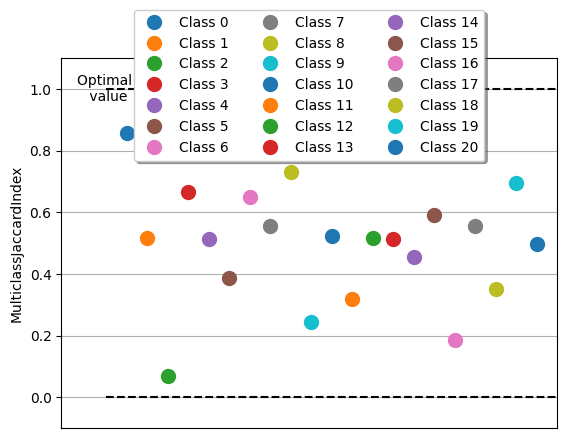

In [54]:
metric.plot()

### for image in dataset

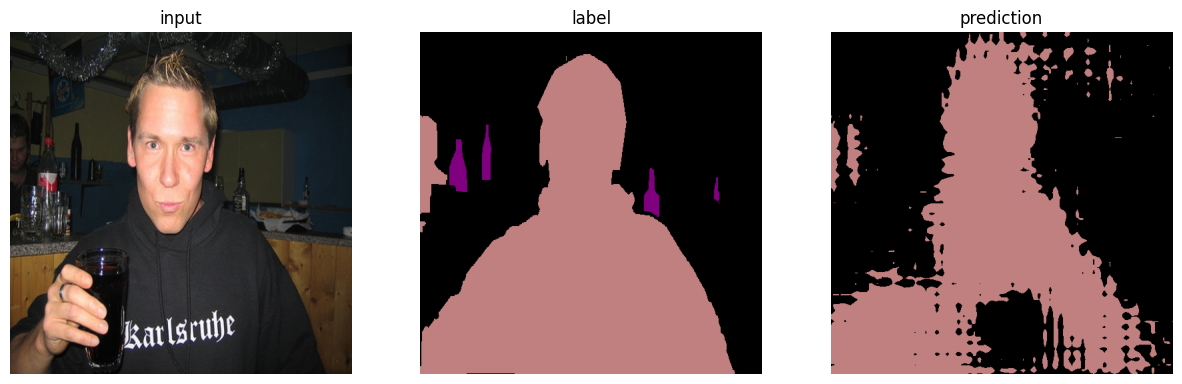

In [55]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

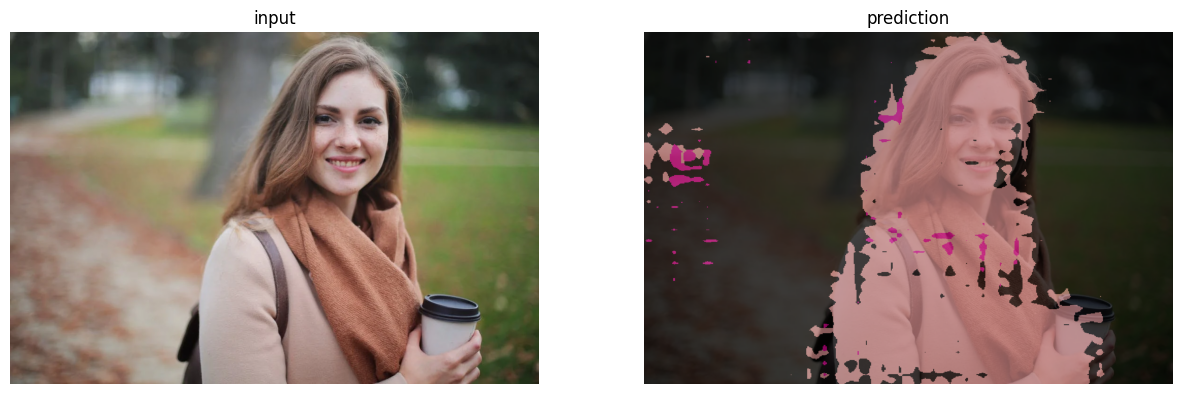

In [56]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )